In [ ]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots ego box/trajectory and nearby agent boxes/trajectories for a single frame.

Usage:
    python tools/simple_navsim_plot.py path/to/vad_navsim_infos.pkl --frame 0
"""

from __future__ import annotations

import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from collections import OrderedDict


# Strong, saturated primary palette (진한 원색들)
CLASS_PALETTE = {
    "vehicle": "#0B6EF6",       # vivid blue
    "pedestrian": "#D7263D",    # vivid red
    "bicycle": "#0FBF2F",       # vivid green
    "traffic_cone": "#FF7F11",  # vivid orange
    "barrier": "#6A00F4",       # vivid purple
    "czone_sign": "#A52A2A",    # brownish (strong)
    "generic_object": "#FF1493",# deep pink
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.6) -> Tuple[float, float, float]:
    """Return a darker RGB tuple by multiplying components by factor and clamping to [0,1]."""
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    """Normalize class/name string to a canonical key for palette lookup.

    Examples: 'Traffic Cone' -> 'traffic_cone', b'Vehicle' -> 'vehicle'
    """
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    return s


# Cache for deterministic colors for unknown classes
_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    """Return a deterministic vivid RGB color for a given normalized class name.

    Uses a simple hashing into HSV hue space and converts to RGB. Cached so the
    same class always maps to the same color during a session.
    """
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]

    # Deterministic pseudo-random hue from the class name
    h = (abs(hash(key)) % 360) / 360.0
    s = 0.85
    v = 0.95
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    """Convert step-wise offsets [N, 2] into positions in the same frame."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    return np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    """Compute rectangle corners for a 2D oriented box."""
    cx, cy = center_xy
    dx = length / 2.0
    dy = width / 2.0
    corners = np.array(
        [
            [dx, dy],
            [dx, -dy],
            [-dx, -dy],
            [-dx, dy],
        ],
        dtype=np.float32,
    )
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T
    return rotated + np.array([cx, cy], dtype=np.float32)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    """Load the full infos list from a NavSim infos pickle.

    This function reads the pickle ONCE and returns the list of infos. Indexing
    into the returned sequence should be done by the caller to avoid re-reading
    the pickle file repeatedly (which is expensive).
    """
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos


def plot_scene(info: Dict, title: str | None = None):
    """Visualize ego and agent boxes plus their trajectories.

    Colors are assigned per-class using CLASS_PALETTE. For any class not in
    the palette we deterministically generate a vivid color. The same color is
    used for box fill, box edge, and trajectory so visuals are consistent
    across instances of the same class.
    """
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    # Ego box (Pacifica dimensions)
    ego_length, ego_width = 5.176, 2.297
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0), closed=True, facecolor="dimgray", edgecolor="black")
    ax.add_patch(ego_poly)

    # Ego history / future trajectories
    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        ax.plot(ego_hist_positions[:, 0], ego_hist_positions[:, 1], color="#0B6EF6", linewidth=2, label="Ego history")

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        ax.plot(ego_fut_positions[:, 0], ego_fut_positions[:, 1], color="#0FBF2F", linewidth=2, label="Ego future")

    # Agent boxes / trajectories
    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)

    boxes = boxes[valid_mask]
    names = names[valid_mask]

    # Precompute per-class color mapping for this scene so same class -> same color
    class_color_map: Dict[str, Tuple[float, float, float]] = {}

    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        color_cycle = plt.cm.get_cmap("tab20", max(1, len(boxes)))

        for idx, (box, name) in enumerate(zip(boxes, names)):
            # If we don't have futures/masks for each box, prepare defaults
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2), dtype=np.float32)
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,), dtype=np.float32)

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]

            # Normalize name to canonical key
            cname = _normalize_name(name)

            # Determine base color (RGB tuple)
            if cname in CLASS_PALETTE:
                base_rgb = mcolors.to_rgb(CLASS_PALETTE[cname])
            else:
                # Deterministic assignment for unknown classes
                base_rgb = _deterministic_color_for(cname)

            # Store mapping so subsequent instances reuse same color
            class_color_map[cname] = base_rgb

            # Colors used for drawing: face (semi-transparent), edge (darker), traj (darker)
            face_rgba = (*base_rgb, 0.6)
            edge_rgb = _darker(base_rgb, factor=0.4)
            edge_color = edge_rgb
            traj_color = edge_rgb

            poly = Polygon(
                box_corners(center, length, width, yaw),
                closed=True,
                facecolor=face_rgba,
                edgecolor=edge_color,
                linewidth=1.8,
            )
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                traj_positions = np.vstack([center, center + np.cumsum(traj_offsets, axis=0)])
                # Plot trajectory using same class color
                ax.plot(traj_positions[:, 0], traj_positions[:, 1], color=traj_color, linewidth=2, label=cname)

    # Deduplicate legend entries so each class appears once instead of once per-instance
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        unique = OrderedDict()
        for h, l in zip(handles, labels):
            if l not in unique:
                unique[l] = h
        ax.legend(list(unique.values()), list(unique.keys()), loc="upper right", fontsize=9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.tight_layout()
    return fig, ax


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int], out_path: Path, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    - infos: sequence returned by `load_infos` (list-like)
    - frame_indices: iterable of integer frame indices to render in order
    - out_path: output path for the video (mp4)

    The function writes temporary PNG frames and uses imageio to create an MP4. If
    `imageio` is not available it will raise an informative ImportError.
    """
    try:
        import imageio.v2 as imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)
    finally:
        tmp_dir.cleanup()


In [18]:
# Update these variables before running the script.
pkl = "data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl"  # e.g., "data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl"
frame_idx = 0

if not pkl:
    raise ValueError("Please set `pkl` to the path of a NavSim info pickle file.")

pkl_path = Path(pkl)
# Load the entire infos list once and index into it below (do not re-read the pickle each time)
infos = load_infos(pkl_path)
info = infos[frame_idx]


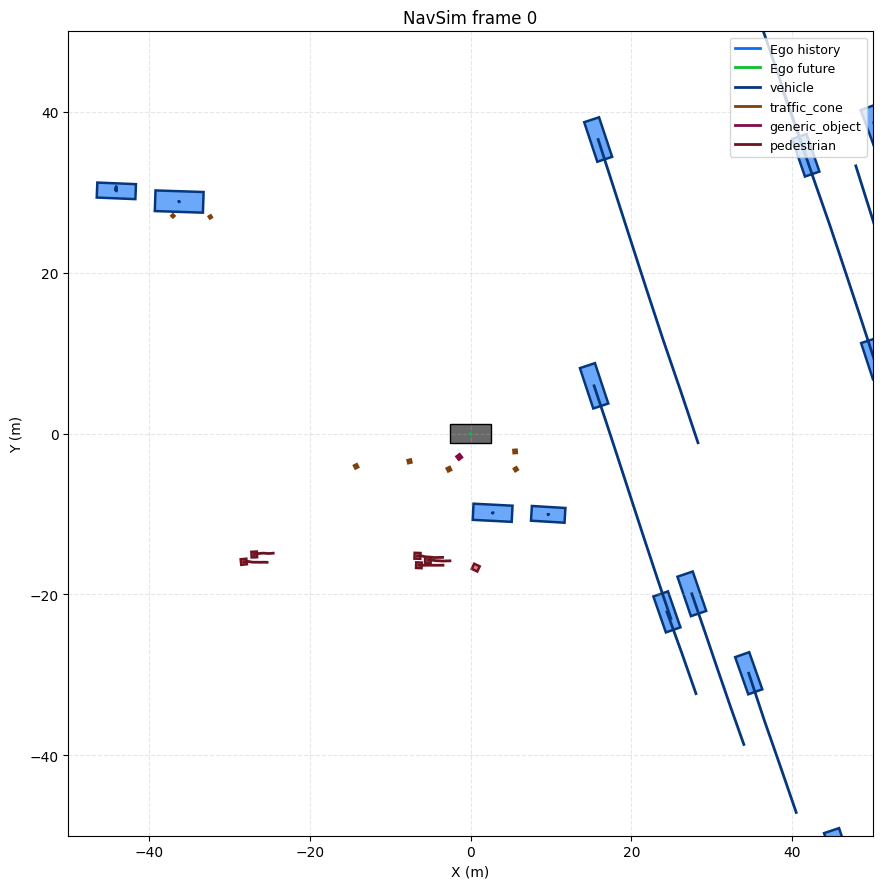

In [21]:
# Plot the chosen frame (already loaded above)
fig, ax = plot_scene(info, title=f"NavSim frame {frame_idx}")
out_path = pkl_path.with_name(f"{pkl_path.stem}_frame{frame_idx}.png")
fig.savefig(out_path, dpi=150)
plt.show()
plt.close(fig)

# Example: create a short video from a sequence of frames (uncomment to run)
# Ensure you have imageio installed: pip install imageio
# frame_indices = range(0, min(50, len(infos)))
# out_video = pkl_path.with_name(f"{pkl_path.stem}_frames.mp4")
# render_infos_to_video(infos, frame_indices, out_video, dpi=150, fps=8)


In [25]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots ego box/trajectory and nearby agent boxes/trajectories for a single frame.

Usage:
    python tools/simple_navsim_plot.py path/to/vad_navsim_infos.pkl --frame 0
"""

from __future__ import annotations

import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from collections import OrderedDict


# Bright, vivid color palette (밝고 쨍한 색상들)
CLASS_PALETTE = {
    "vehicle": "#00BFFF",       # bright sky blue
    "pedestrian": "#FF3030",    # bright red
    "bicycle": "#00FF7F",       # bright spring green
    "traffic_cone": "#FFA500",  # bright orange
    "barrier": "#9370DB",       # bright medium purple
    "czone_sign": "#FF6347",    # bright tomato
    "generic_object": "#FF1493",# bright deep pink
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.7) -> Tuple[float, float, float]:
    """Return a darker RGB tuple by multiplying components by factor and clamping to [0,1]."""
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    """Normalize class/name string to a canonical key for palette lookup.

    Examples: 'Traffic Cone' -> 'traffic_cone', b'Vehicle' -> 'vehicle'
    """
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    return s


# Cache for deterministic colors for unknown classes
_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    """Return a deterministic bright RGB color for a given normalized class name.

    Uses a simple hashing into HSV hue space and converts to RGB. Cached so the
    same class always maps to the same color during a session.
    """
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]

    # Deterministic pseudo-random hue from the class name
    h = (abs(hash(key)) % 360) / 360.0
    s = 0.9  # Higher saturation for brighter colors
    v = 1.0  # Maximum brightness
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    """Convert step-wise offsets [N, 2] into positions in the same frame."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    return np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    """Compute rectangle corners for a 2D oriented box."""
    cx, cy = center_xy
    dx = length / 2.0
    dy = width / 2.0
    corners = np.array(
        [
            [dx, dy],
            [dx, -dy],
            [-dx, -dy],
            [-dx, dy],
        ],
        dtype=np.float32,
    )
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T
    return rotated + np.array([cx, cy], dtype=np.float32)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    """Load the full infos list from a NavSim infos pickle.

    This function reads the pickle ONCE and returns the list of infos. Indexing
    into the returned sequence should be done by the caller to avoid re-reading
    the pickle file repeatedly (which is expensive).
    """
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos


def plot_scene(info: Dict, title: str | None = None):
    """Visualize ego and agent boxes plus their trajectories.

    Colors are assigned per-class using CLASS_PALETTE. For any class not in
    the palette we deterministically generate a bright color. The same color is
    used for box fill, box edge, and trajectory so visuals are consistent
    across instances of the same class.
    """
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    # Ego box (Pacifica dimensions)
    ego_length, ego_width = 5.176, 2.297
    ego_color = "#FFD700"  # bright gold
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0), closed=True, facecolor=ego_color, edgecolor="#B8860B", linewidth=2)
    ax.add_patch(ego_poly)

    # Ego history / future trajectories
    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        ax.plot(ego_hist_positions[:, 0], ego_hist_positions[:, 1], color="#00BFFF", linewidth=3)

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        ax.plot(ego_fut_positions[:, 0], ego_fut_positions[:, 1], color="#00FF7F", linewidth=3)

    # Agent boxes / trajectories
    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)

    boxes = boxes[valid_mask]
    names = names[valid_mask]

    # Precompute per-class color mapping for this scene so same class -> same color
    class_color_map: Dict[str, Tuple[float, float, float]] = {}

    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        color_cycle = plt.cm.get_cmap("tab20", max(1, len(boxes)))

        for idx, (box, name) in enumerate(zip(boxes, names)):
            # If we don't have futures/masks for each box, prepare defaults
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2), dtype=np.float32)
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,), dtype=np.float32)

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]

            # Normalize name to canonical key
            cname = _normalize_name(name)

            # Determine base color (RGB tuple)
            if cname in CLASS_PALETTE:
                base_rgb = mcolors.to_rgb(CLASS_PALETTE[cname])
            else:
                # Deterministic assignment for unknown classes
                base_rgb = _deterministic_color_for(cname)

            # Store mapping so subsequent instances reuse same color
            class_color_map[cname] = base_rgb

            # Colors used for drawing: face (semi-transparent), edge (darker), traj (darker)
            face_rgba = (*base_rgb, 0.7)  # Slightly more opaque for brighter appearance
            edge_rgb = _darker(base_rgb, factor=0.6)  # Less darkening for brighter edges
            edge_color = edge_rgb
            traj_color = base_rgb  # Use base color for trajectory to keep it bright

            poly = Polygon(
                box_corners(center, length, width, yaw),
                closed=True,
                facecolor=face_rgba,
                edgecolor=edge_color,
                linewidth=2.0,  # Slightly thicker edges
            )
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                traj_positions = np.vstack([center, center + np.cumsum(traj_offsets, axis=0)])
                ax.plot(traj_positions[:, 0], traj_positions[:, 1], color=traj_color, linewidth=3)

    # Create legend with unique class names only
    class_handles = []
    class_labels = []

    # Add ego to legend
    class_handles.append(plt.Rectangle((0,0),1,1, facecolor="#FFD700", edgecolor="#B8860B"))
    class_labels.append("ego")

    # Add other classes
    for cname, rgb in class_color_map.items():
        class_handles.append(plt.Rectangle((0,0),1,1, facecolor=rgb, alpha=0.7))
        class_labels.append(cname)

    if class_handles:
        ax.legend(class_handles, class_labels, loc="upper right", fontsize=9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.tight_layout()
    return fig, ax


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int], out_path: Path, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    - infos: sequence returned by `load_infos` (list-like)
    - frame_indices: iterable of integer frame indices to render in order
    - out_path: output path for the video (mp4)

    The function writes temporary PNG frames and uses imageio to create an MP4. If
    `imageio` is not available it will raise an informative ImportError.
    """
    try:
        import imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)
    finally:
        tmp_dir.cleanup()

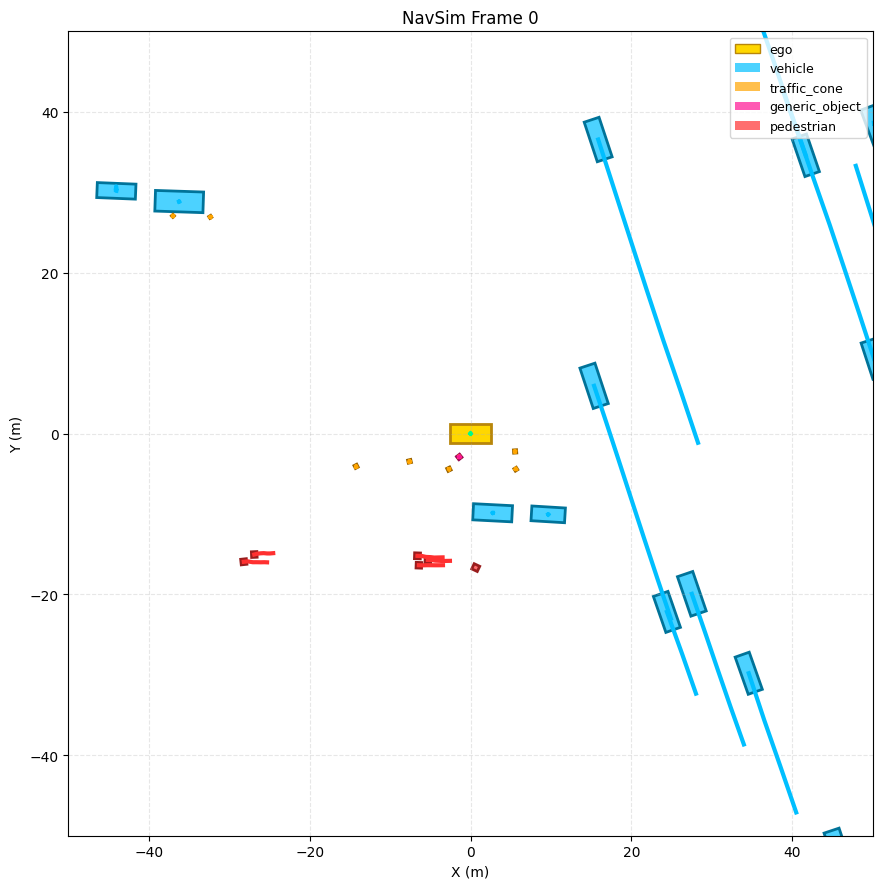

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1350) to (1504, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [27]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[0]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    frame_indices=range(0, 300),  # 0-49 프레임
    out_path=Path("navsim.mp4"),
    fps=10
)

In [37]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots ego box/trajectory and nearby agent boxes/trajectories for a single frame.

Usage:
    python tools/simple_navsim_plot.py path/to/vad_navsim_infos.pkl --frame 0
"""

from __future__ import annotations

import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from collections import OrderedDict


# Bright, vivid color palette (밝고 쨍한 색상들)
CLASS_PALETTE = {
    "vehicle": "#00BFFF",       # bright sky blue
    "pedestrian": "#FF3030",    # bright red
    "bicycle": "#00FF7F",       # bright spring green
    "traffic_cone": "#FFA500",  # bright orange
    "barrier": "#9370DB",       # bright medium purple
    "czone_sign": "#FF6347",    # bright tomato
    "generic_object": "#FF1493",# bright deep pink
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.7) -> Tuple[float, float, float]:
    """Return a darker RGB tuple by multiplying components by factor and clamping to [0,1]."""
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    """Normalize class/name string to a canonical key for palette lookup.

    Examples: 'Traffic Cone' -> 'traffic_cone', b'Vehicle' -> 'vehicle'
    """
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    return s


# Cache for deterministic colors for unknown classes
_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    """Return a deterministic bright RGB color for a given normalized class name.

    Uses a simple hashing into HSV hue space and converts to RGB. Cached so the
    same class always maps to the same color during a session.
    """
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]

    # Deterministic pseudo-random hue from the class name
    h = (abs(hash(key)) % 360) / 360.0
    s = 0.9  # Higher saturation for brighter colors
    v = 1.0  # Maximum brightness
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    """Convert step-wise offsets [N, 2] into positions in the same frame."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    return np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    """Compute rectangle corners for a 2D oriented box."""
    cx, cy = center_xy
    dx = length / 2.0
    dy = width / 2.0
    corners = np.array(
        [
            [dx, dy],
            [dx, -dy],
            [-dx, -dy],
            [-dx, dy],
        ],
        dtype=np.float32,
    )
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T
    return rotated + np.array([cx, cy], dtype=np.float32)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    """Load the full infos list from a NavSim infos pickle.

    This function reads the pickle ONCE and returns the list of infos. Indexing
    into the returned sequence should be done by the caller to avoid re-reading
    the pickle file repeatedly (which is expensive).
    """
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos


def plot_scene(info: Dict, title: str | None = None):
    """Visualize ego and agent boxes plus their trajectories.

    Colors are assigned per-class using CLASS_PALETTE. For any class not in
    the palette we deterministically generate a bright color. The same color is
    used for box fill, box edge, and trajectory so visuals are consistent
    across instances of the same class.
    """
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    # Ego box (Pacifica dimensions)
    ego_length, ego_width = 5.176, 2.297
    ego_color = "#32CD32"  # bright lime green
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0), closed=True, facecolor=ego_color, edgecolor="#228B22", linewidth=2)
    ax.add_patch(ego_poly)

    # Ego history / future trajectories
    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        # Draw with gradient - older points more transparent
        for i in range(len(ego_hist_positions) - 1):
            alpha = 0.1 + 0.9 * (i / (len(ego_hist_positions) - 1))  # 0.1 to 1.0
            ax.plot(ego_hist_positions[i:i+2, 0], ego_hist_positions[i:i+2, 1],
                   color="#00BFFF", linewidth=3, alpha=alpha)

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        # Draw with gradient - future points more transparent
        for i in range(len(ego_fut_positions) - 1):
            alpha = 1.0 - 0.9 * (i / (len(ego_fut_positions) - 1))  # 1.0 to 0.1
            ax.plot(ego_fut_positions[i:i+2, 0], ego_fut_positions[i:i+2, 1],
                   color="#00FF7F", linewidth=3, alpha=alpha)

    # Agent boxes / trajectories
    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)

    boxes = boxes[valid_mask]
    names = names[valid_mask]

    # Precompute per-class color mapping for this scene so same class -> same color
    class_color_map: Dict[str, Tuple[float, float, float]] = {}

    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        color_cycle = plt.cm.get_cmap("tab20", max(1, len(boxes)))

        for idx, (box, name) in enumerate(zip(boxes, names)):
            # If we don't have futures/masks for each box, prepare defaults
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2), dtype=np.float32)
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,), dtype=np.float32)

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]

            # Normalize name to canonical key
            cname = _normalize_name(name)

            # Determine base color (RGB tuple)
            if cname in CLASS_PALETTE:
                base_rgb = mcolors.to_rgb(CLASS_PALETTE[cname])
            else:
                # Deterministic assignment for unknown classes
                base_rgb = _deterministic_color_for(cname)

            # Store mapping so subsequent instances reuse same color
            class_color_map[cname] = base_rgb

            # Colors used for drawing: face (semi-transparent), edge (darker), traj (darker)
            face_rgba = (*base_rgb, 0.7)  # Slightly more opaque for brighter appearance
            edge_rgb = _darker(base_rgb, factor=0.6)  # Less darkening for brighter edges
            edge_color = edge_rgb
            traj_color = base_rgb  # Use base color for trajectory to keep it bright

            poly = Polygon(
                box_corners(center, length, width, yaw),
                closed=True,
                facecolor=face_rgba,
                edgecolor=edge_color,
                linewidth=2.0,  # Slightly thicker edges
            )
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                traj_positions = np.vstack([center, center + np.cumsum(traj_offsets, axis=0)])
                # Draw with gradient - future points more transparent
                for i in range(len(traj_positions) - 1):
                    alpha = 1.0 - 0.9 * (i / (len(traj_positions) - 1))  # 1.0 to 0.1
                    ax.plot(traj_positions[i:i+2, 0], traj_positions[i:i+2, 1],
                           color=traj_color, linewidth=3, alpha=alpha)

    # Create legend with unique class names only
    class_handles = []
    class_labels = []

    # Add ego to legend
    class_handles.append(plt.Rectangle((0,0),1,1, facecolor="#32CD32", edgecolor="#228B22"))
    class_labels.append("ego")

    # Add other classes
    for cname, rgb in class_color_map.items():
        class_handles.append(plt.Rectangle((0,0),1,1, facecolor=rgb, alpha=0.7))
        class_labels.append(cname)

    if class_handles:
        ax.legend(class_handles, class_labels, loc="upper right", fontsize=9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.tight_layout()
    return fig, ax


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int], out_path: Path, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    - infos: sequence returned by `load_infos` (list-like)
    - frame_indices: iterable of integer frame indices to render in order
    - out_path: output path for the video (mp4)

    The function writes temporary PNG frames and uses imageio to create an MP4. If
    `imageio` is not available it will raise an informative ImportError.
    """
    try:
        import imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)
    finally:
        tmp_dir.cleanup()

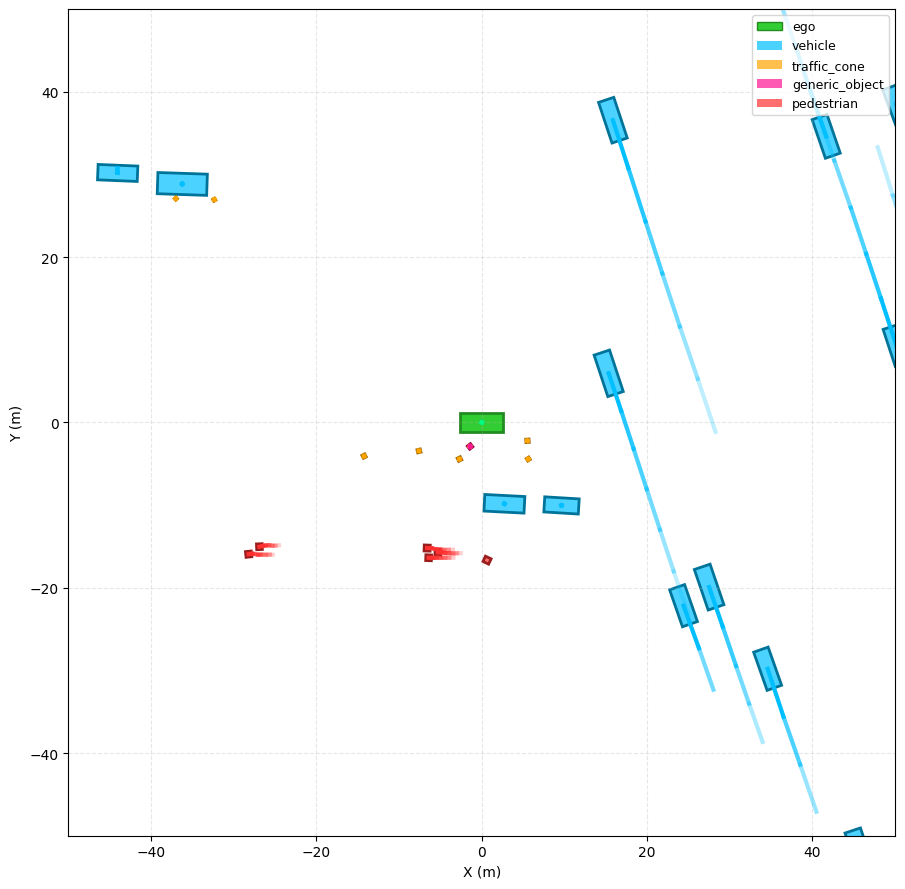

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1350) to (1504, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [38]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[0]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    frame_indices=range(250, 300),  # 0-49 프레임
    out_path=Path("navsim3.mp4"),
    fps=5
)

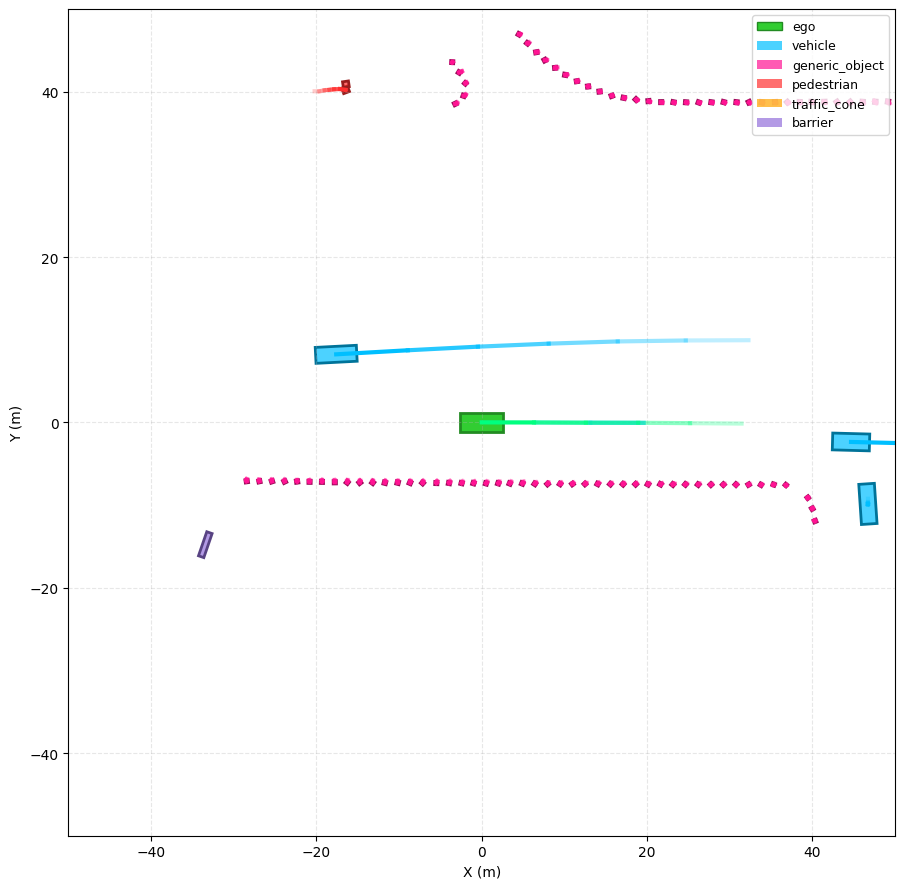

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1350) to (1504, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [40]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_train_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[0]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    frame_indices=range(0, 300),  # 0-49 프레임
    out_path=Path("navsim_train.mp4"),
    fps=5
)

In [45]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots ego box/trajectory and nearby agent boxes/trajectories for a single frame.

Usage:
    python tools/simple_navsim_plot.py path/to/vad_navsim_infos.pkl --frame 0
"""

from __future__ import annotations

import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from collections import OrderedDict


# Bright, vivid color palette (밝고 쨍한 색상들)
CLASS_PALETTE = {
    "vehicle": "#00BFFF",       # bright sky blue
    "pedestrian": "#FF3030",    # bright red
    "bicycle": "#00FF7F",       # bright spring green
    "traffic_cone": "#FFA500",  # bright orange
    "barrier": "#9370DB",       # bright medium purple
    "czone_sign": "#FF6347",    # bright tomato
    "generic_object": "#FF1493",# bright deep pink
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.7) -> Tuple[float, float, float]:
    """Return a darker RGB tuple by multiplying components by factor and clamping to [0,1]."""
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    """Normalize class/name string to a canonical key for palette lookup.

    Examples: 'Traffic Cone' -> 'traffic_cone', b'Vehicle' -> 'vehicle'
    """
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    return s


# Cache for deterministic colors for unknown classes
_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    """Return a deterministic bright RGB color for a given normalized class name.

    Uses a simple hashing into HSV hue space and converts to RGB. Cached so the
    same class always maps to the same color during a session.
    """
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]

    # Deterministic pseudo-random hue from the class name
    h = (abs(hash(key)) % 360) / 360.0
    s = 0.9  # Higher saturation for brighter colors
    v = 1.0  # Maximum brightness
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    """Convert step-wise offsets [N, 2] into positions in the same frame."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    return np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    """Compute rectangle corners for a 2D oriented box."""
    cx, cy = center_xy
    dx = length / 2.0
    dy = width / 2.0
    corners = np.array(
        [
            [dx, dy],
            [dx, -dy],
            [-dx, -dy],
            [-dx, dy],
        ],
        dtype=np.float32,
    )
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T
    return rotated + np.array([cx, cy], dtype=np.float32)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    """Load the full infos list from a NavSim infos pickle.

    This function reads the pickle ONCE and returns the list of infos. Indexing
    into the returned sequence should be done by the caller to avoid re-reading
    the pickle file repeatedly (which is expensive).
    """
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos


def plot_scene(info: Dict, title: str | None = None):
    """Visualize ego and agent boxes plus their trajectories.

    Colors are assigned per-class using CLASS_PALETTE. For any class not in
    the palette we deterministically generate a bright color. The same color is
    used for box fill, box edge, and trajectory so visuals are consistent
    across instances of the same class.
    """
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    # Ego box (Pacifica dimensions)
    ego_length, ego_width = 5.176, 2.297
    ego_color = "#32CD32"  # bright lime green
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0), closed=True, facecolor=ego_color, edgecolor="#228B22", linewidth=2)
    ax.add_patch(ego_poly)

    # Ego history / future trajectories
    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        # Draw with smooth gradient using LineCollection
        if len(ego_hist_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_hist_positions[i:i+2] for i in range(len(ego_hist_positions)-1)])
            alphas = np.linspace(0.1, 1.0, len(segments))
            lc = LineCollection(segments, colors="#00BFFF", linewidths=3, alpha=alphas)
            ax.add_collection(lc)

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        # Draw with smooth gradient using LineCollection
        if len(ego_fut_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_fut_positions[i:i+2] for i in range(len(ego_fut_positions)-1)])
            alphas = np.linspace(1.0, 0.1, len(segments))
            lc = LineCollection(segments, colors="#00FF7F", linewidths=3, alpha=alphas)
            ax.add_collection(lc)

    # Agent boxes / trajectories
    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)

    boxes = boxes[valid_mask]
    names = names[valid_mask]

    # Precompute per-class color mapping for this scene so same class -> same color
    class_color_map: Dict[str, Tuple[float, float, float]] = {}

    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        color_cycle = plt.cm.get_cmap("tab20", max(1, len(boxes)))

        for idx, (box, name) in enumerate(zip(boxes, names)):
            # If we don't have futures/masks for each box, prepare defaults
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2), dtype=np.float32)
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,), dtype=np.float32)

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]

            # Normalize name to canonical key
            cname = _normalize_name(name)

            # Determine base color (RGB tuple)
            if cname in CLASS_PALETTE:
                base_rgb = mcolors.to_rgb(CLASS_PALETTE[cname])
            else:
                # Deterministic assignment for unknown classes
                base_rgb = _deterministic_color_for(cname)

            # Store mapping so subsequent instances reuse same color
            class_color_map[cname] = base_rgb

            # Colors used for drawing: face (semi-transparent), edge (darker), traj (darker)
            face_rgba = (*base_rgb, 0.7)  # Slightly more opaque for brighter appearance
            edge_rgb = _darker(base_rgb, factor=0.6)  # Less darkening for brighter edges
            edge_color = edge_rgb
            traj_color = base_rgb  # Use base color for trajectory to keep it bright

            poly = Polygon(
                box_corners(center, length, width, yaw),
                closed=True,
                facecolor=face_rgba,
                edgecolor=edge_color,
                linewidth=2.0,  # Slightly thicker edges
            )
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                traj_positions = np.vstack([center, center + np.cumsum(traj_offsets, axis=0)])
                # Draw with smooth gradient using LineCollection
                if len(traj_positions) > 1:
                    from matplotlib.collections import LineCollection
                    segments = np.array([traj_positions[i:i+2] for i in range(len(traj_positions)-1)])
                    alphas = np.linspace(1.0, 0.1, len(segments))
                    lc = LineCollection(segments, colors=traj_color, linewidths=3, alpha=alphas)
                    ax.add_collection(lc)

    # Create fixed legend with all classes
    class_handles = []
    class_labels = []

    # Add ego to legend
    class_handles.append(plt.Rectangle((0,0),1,1, facecolor="#32CD32", edgecolor="#228B22"))
    class_labels.append("ego")

    # Add all fixed classes with their colors
    fixed_classes = ["vehicle", "pedestrian", "bicycle", "traffic_cone", "barrier", "czone_sign", "generic_object"]
    for class_name in fixed_classes:
        if class_name in CLASS_PALETTE:
            color = CLASS_PALETTE[class_name]
            class_handles.append(plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.7))
            class_labels.append(class_name)

    ax.legend(class_handles, class_labels, loc="upper right", fontsize=9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.tight_layout()
    return fig, ax


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int], out_path: Path, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    - infos: sequence returned by `load_infos` (list-like)
    - frame_indices: iterable of integer frame indices to render in order
    - out_path: output path for the video (mp4)

    The function writes temporary PNG frames and uses imageio to create an MP4. If
    `imageio` is not available it will raise an informative ImportError.
    """
    try:
        import imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)
    finally:
        tmp_dir.cleanup()

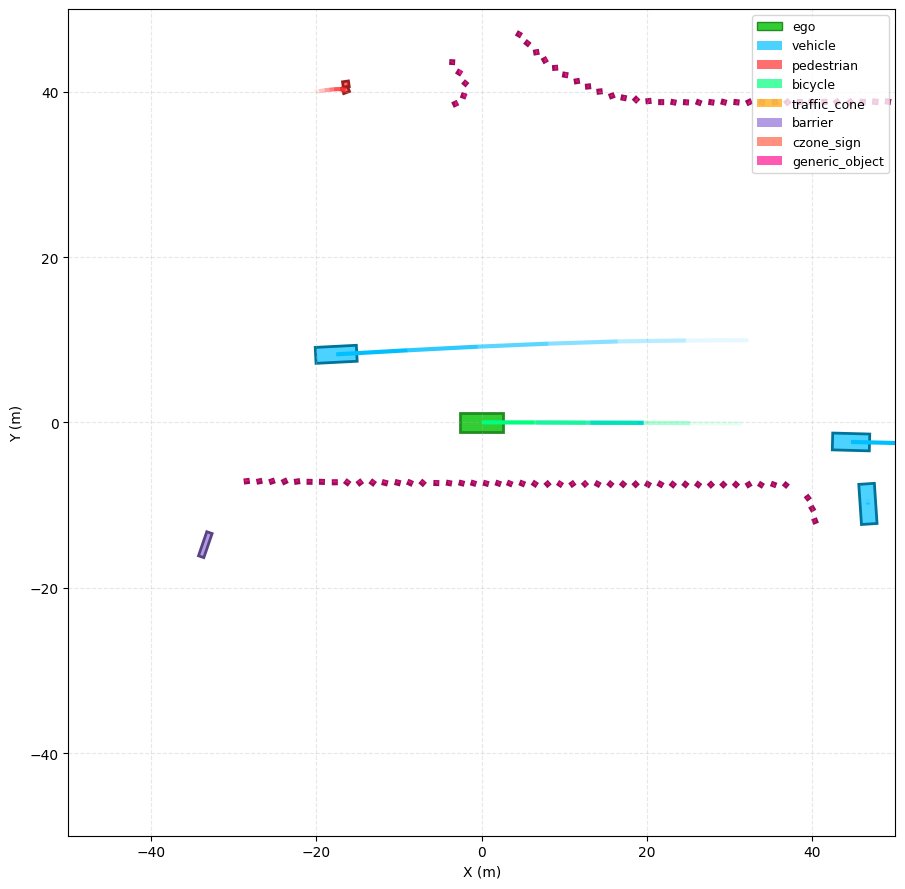

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1350) to (1504, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [46]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_train_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[0]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    frame_indices=range(0, 300),  # 0-49 프레임
    out_path=Path("navsim_train_2.mp4"),
    fps=5
)

In [85]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots ego box/trajectory and nearby agent boxes/trajectories for a single frame.
Rotated 90 degrees counterclockwise for better visualization.

Usage:
    python tools/simple_navsim_plot_rotated.py path/to/vad_navsim_infos.pkl --frame 0
"""

from __future__ import annotations

import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from collections import OrderedDict


# Bright, vivid color palette (밝고 쨍한 색상들)
CLASS_PALETTE = {
    "vehicle": "#00BFFF",       # bright sky blue
    "pedestrian": "#FF3030",    # bright red
    "bicycle": "#00FF7F",       # bright spring green
    "traffic_cone": "#FFA500",  # bright orange
    "barrier": "#9370DB",       # bright medium purple
    "czone_sign": "#FF6347",    # bright tomato
    "generic_object": "#FF1493",# bright deep pink
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.7) -> Tuple[float, float, float]:
    """Return a darker RGB tuple by multiplying components by factor and clamping to [0,1]."""
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    """Normalize class/name string to a canonical key for palette lookup.

    Examples: 'Traffic Cone' -> 'traffic_cone', b'Vehicle' -> 'vehicle'
    """
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower()
    s = s.replace(" ", "_")
    s = s.replace("-", "_")
    return s


# Cache for deterministic colors for unknown classes
_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    """Return a deterministic bright RGB color for a given normalized class name.

    Uses a simple hashing into HSV hue space and converts to RGB. Cached so the
    same class always maps to the same color during a session.
    """
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]

    # Deterministic pseudo-random hue from the class name
    h = (abs(hash(key)) % 360) / 360.0
    s = 0.9  # Higher saturation for brighter colors
    v = 1.0  # Maximum brightness
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def rotate_point_90ccw(point: np.ndarray) -> np.ndarray:
    """Rotate a point or array of points 90 degrees counterclockwise.

    For 90° CCW rotation: (x, y) -> (-y, x)
    """
    if point.ndim == 1:
        # Single point [x, y] -> [-y, x]
        return np.array([-point[1], point[0]], dtype=np.float32)
    else:
        # Array of points [[x1, y1], [x2, y2], ...] -> [[-y1, x1], [-y2, x2], ...]
        return np.column_stack([-point[:, 1], point[:, 0]]).astype(np.float32)


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    """Convert step-wise offsets [N, 2] into positions in the same frame."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    positions = np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])

    # Apply 90 degree rotation to all positions
    return rotate_point_90ccw(positions)


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    """Compute rectangle corners for a 2D oriented box, rotated 90 degrees CCW."""
    cx, cy = center_xy
    dx = length / 2.0
    dy = width / 2.0
    corners = np.array(
        [
            [dx, dy],
            [dx, -dy],
            [-dx, -dy],
            [-dx, dy],
        ],
        dtype=np.float32,
    )

    # Apply original rotation (yaw)
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T

    # Translate to center
    positioned = rotated + np.array([cx, cy], dtype=np.float32)

    # Apply 90 degree CCW rotation to the entire box
    return rotate_point_90ccw(positioned)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    """Load the full infos list from a NavSim infos pickle.

    This function reads the pickle ONCE and returns the list of infos. Indexing
    into the returned sequence should be done by the caller to avoid re-reading
    the pickle file repeatedly (which is expensive).
    """
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos


def plot_scene(info: Dict, title: str | None = None):
    """Visualize ego and agent boxes plus their trajectories.

    Colors are assigned per-class using CLASS_PALETTE. For any class not in
    the palette we deterministically generate a bright color. The same color is
    used for box fill, box edge, and trajectory so visuals are consistent
    across instances of the same class.

    The entire scene is rotated 90 degrees counterclockwise.
    """
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlabel("Y (m)")  # Swapped due to 90° rotation
    ax.set_ylabel("X (m)")  # Swapped due to 90° rotation

    # Ego box (Pacifica dimensions) - rotated 90 degrees CCW
    ego_length, ego_width = 5.176, 2.297
    ego_color = "#32CD32"  # bright lime green
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0), closed=True, facecolor=ego_color, edgecolor="#228B22", linewidth=2)
    ax.add_patch(ego_poly)

    # Ego history / future trajectories
    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        # Draw with smooth gradient using LineCollection (yellow color, recent past = darker)
        if len(ego_hist_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_hist_positions[i:i+2] for i in range(len(ego_hist_positions)-1)])
            alphas = np.linspace(1.0, 0.1, len(segments))  # Reversed: recent past (start) = darker
            lc = LineCollection(segments, colors="#FFD700", linewidths=3, alpha=alphas)  # Gold/Yellow color
            ax.add_collection(lc)

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        # Draw with smooth gradient using LineCollection
        if len(ego_fut_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_fut_positions[i:i+2] for i in range(len(ego_fut_positions)-1)])
            alphas = np.linspace(1.0, 0.1, len(segments))
            lc = LineCollection(segments, colors="#00FF7F", linewidths=3, alpha=alphas)
            ax.add_collection(lc)

    # Agent boxes / trajectories
    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)

    boxes = boxes[valid_mask]
    names = names[valid_mask]

    # Precompute per-class color mapping for this scene so same class -> same color
    class_color_map: Dict[str, Tuple[float, float, float]] = {}

    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        color_cycle = plt.cm.get_cmap("tab20", max(1, len(boxes)))

        for idx, (box, name) in enumerate(zip(boxes, names)):
            # If we don't have futures/masks for each box, prepare defaults
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2), dtype=np.float32)
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,), dtype=np.float32)

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]

            # Normalize name to canonical key
            cname = _normalize_name(name)

            # Determine base color (RGB tuple)
            if cname in CLASS_PALETTE:
                base_rgb = mcolors.to_rgb(CLASS_PALETTE[cname])
            else:
                # Deterministic assignment for unknown classes
                base_rgb = _deterministic_color_for(cname)

            # Store mapping so subsequent instances reuse same color
            class_color_map[cname] = base_rgb

            # Colors used for drawing: face (semi-transparent), edge (darker), traj (darker)
            face_rgba = (*base_rgb, 0.7)  # Slightly more opaque for brighter appearance
            edge_rgb = _darker(base_rgb, factor=0.6)  # Less darkening for brighter edges
            edge_color = edge_rgb
            traj_color = base_rgb  # Use base color for trajectory to keep it bright

            poly = Polygon(
                box_corners(center, length, width, yaw),
                closed=True,
                facecolor=face_rgba,
                edgecolor=edge_color,
                linewidth=2.0,  # Slightly thicker edges
            )
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                # Apply rotation to center position
                rotated_center = rotate_point_90ccw(np.array(center))
                # Apply rotation to trajectory offsets and create positions
                rotated_offsets = rotate_point_90ccw(traj_offsets)
                traj_positions = np.vstack([rotated_center, rotated_center + np.cumsum(rotated_offsets, axis=0)])

                # Draw with smooth gradient using LineCollection
                if len(traj_positions) > 1:
                    from matplotlib.collections import LineCollection
                    segments = np.array([traj_positions[i:i+2] for i in range(len(traj_positions)-1)])
                    alphas = np.linspace(1.0, 0.1, len(segments))
                    lc = LineCollection(segments, colors=traj_color, linewidths=3, alpha=alphas)
                    ax.add_collection(lc)

    # Create fixed legend with all classes
    class_handles = []
    class_labels = []

    # Add ego to legend
    class_handles.append(plt.Rectangle((0,0),1,1, facecolor="#32CD32", edgecolor="#228B22"))
    class_labels.append("ego")

    # Add all fixed classes with their colors
    fixed_classes = ["vehicle", "pedestrian", "bicycle", "traffic_cone", "barrier", "czone_sign", "generic_object"]
    for class_name in fixed_classes:
        if class_name in CLASS_PALETTE:
            color = CLASS_PALETTE[class_name]
            class_handles.append(plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.7))
            class_labels.append(class_name)

    ax.legend(class_handles, class_labels, loc="upper right", fontsize=9)

    # Swapped limits due to 90° rotation
    ax.set_xlim(-50, 50)  # This is now the Y axis in original coordinates
    ax.set_ylim(-50, 50)  # This is now the X axis in original coordinates
    plt.tight_layout()
    return fig, ax


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int] | None = None, out_path: Path | None = None, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    Args:
        infos: Sequence returned by `load_infos` (list-like).
        frame_indices: Iterable of integer frame indices to render in order.
                      If None, renders all frames from 0 to len(infos)-1.
        out_path: Output path for the video (mp4). If None, defaults to 'navsim_video.mp4'.
        dpi: DPI for rendered frames.
        fps: Frames per second for the output video.

    Raises:
        ImportError: If imageio is not available.
    """
    try:
        import imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    # Set default values if not provided
    if frame_indices is None:
        frame_indices = list(range(len(infos)))

    if out_path is None:
        out_path = Path("navsim_video.mp4")

    # Ensure out_path is a Path object
    if not isinstance(out_path, Path):
        out_path = Path(out_path)

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            if idx >= len(infos):
                print(f"Warning: Frame index {idx} is out of range (max: {len(infos)-1}). Skipping.")
                continue

            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        if not png_paths:
            raise ValueError("No valid frames to render")

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)

        print(f"Video saved to: {out_path}")
        print(f"Total frames rendered: {len(png_paths)}")

    finally:
        tmp_dir.cleanup()

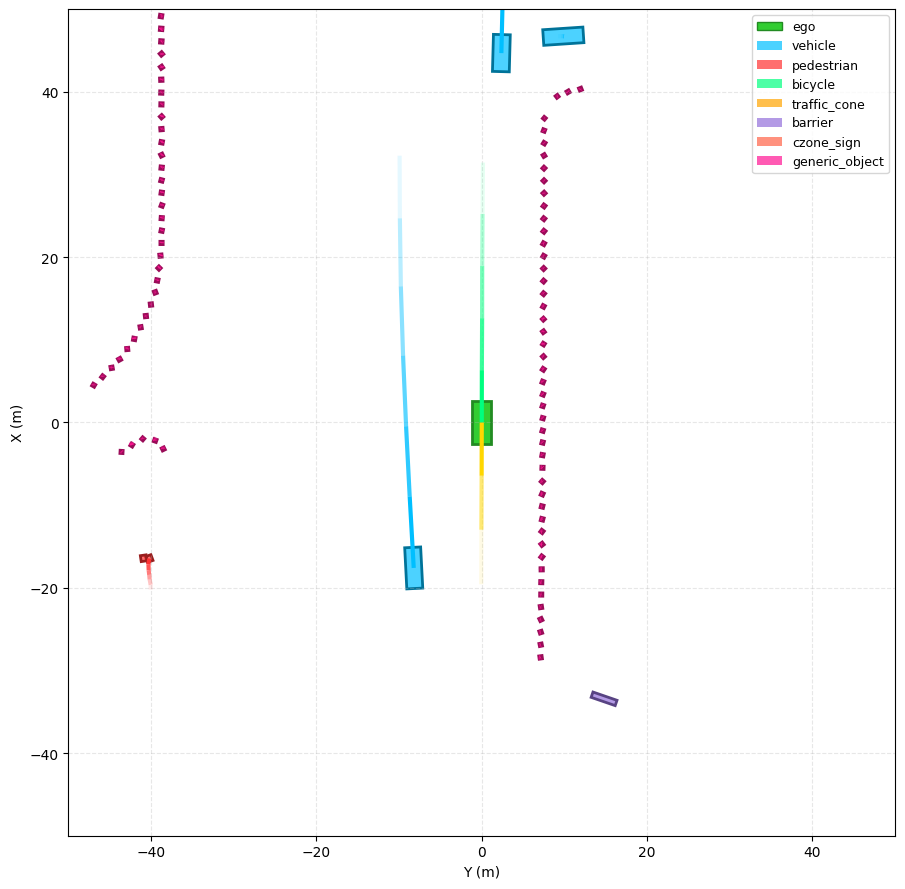

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1350) to (1504, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to: navsim_train_full.mp4
Total frames rendered: 10


In [86]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_train_start0_count2.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[0]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    frame_indices=range(0, 10),
    out_path=Path("navsim_train_full.mp4"),
    fps=5
)

In [39]:
#!/usr/bin/env python3
"""
Quick Matplotlib visualization for NavSim VAD info files.

Plots vector map (aligned to ego and rotated 90° CCW),
ego box/trajectory, and nearby agent boxes/trajectories.
"""

from __future__ import annotations
import pickle
from pathlib import Path
from typing import Dict, Iterable, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from shapely.geometry import Polygon as ShapelyPolygon, LineString, MultiPolygon, MultiLineString
from shapely.affinity import translate, rotate
from pyquaternion import Quaternion


# Bright, vivid color palette (unchanged)
CLASS_PALETTE = {
    "vehicle": "#00BFFF",
    "pedestrian": "#FF3030",
    "bicycle": "#00FF7F",
    "traffic_cone": "#FFA500",
    "barrier": "#9370DB",
    "czone_sign": "#FF6347",
    "generic_object": "#FF1493",
}


def _darker(rgb: Tuple[float, float, float], factor: float = 0.7) -> Tuple[float, float, float]:
    return tuple(max(0.0, min(1.0, c * factor)) for c in rgb)


def _normalize_name(name: str) -> str:
    if isinstance(name, bytes):
        name = name.decode("utf-8")
    s = str(name).strip().lower().replace(" ", "_").replace("-", "_")
    return s


_DETERMINISTIC_COLOR_CACHE: Dict[str, Tuple[float, float, float]] = {}


def _deterministic_color_for(name: str) -> Tuple[float, float, float]:
    key = _normalize_name(name)
    if key in _DETERMINISTIC_COLOR_CACHE:
        return _DETERMINISTIC_COLOR_CACHE[key]
    h = (abs(hash(key)) % 360) / 360.0
    s, v = 0.9, 1.0
    rgb = mcolors.hsv_to_rgb((h, s, v))
    _DETERMINISTIC_COLOR_CACHE[key] = tuple(rgb.tolist())
    return _DETERMINISTIC_COLOR_CACHE[key]


def rotate_point_90ccw(point: np.ndarray) -> np.ndarray:
    if point.ndim == 1:
        return np.array([-point[1], point[0]], dtype=np.float32)
    else:
        return np.column_stack([-point[:, 1], point[:, 0]]).astype(np.float32)


def offsets_to_positions(offsets: np.ndarray, start: Tuple[float, float] = (0.0, 0.0)) -> np.ndarray:
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cumsum = np.cumsum(offsets, axis=0)
    positions = np.vstack([np.asarray(start, dtype=np.float32), cumsum + np.asarray(start, dtype=np.float32)])
    return rotate_point_90ccw(positions)


def box_corners(center_xy: Iterable[float], length: float, width: float, yaw_rad: float) -> np.ndarray:
    cx, cy = center_xy
    dx, dy = length / 2.0, width / 2.0
    corners = np.array([[dx, dy], [dx, -dy], [-dx, -dy], [-dx, dy]], dtype=np.float32)
    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]], dtype=np.float32)
    rotated = corners @ rot.T
    positioned = rotated + np.array([cx, cy], dtype=np.float32)
    return rotate_point_90ccw(positioned)


def load_infos(pkl_path: Path) -> Sequence[Dict]:
    with pkl_path.open("rb") as fp:
        data = pickle.load(fp)
    infos = data.get("infos")
    if infos is None:
        raise KeyError(f"Pickle at {pkl_path} does not contain 'infos' key")
    return infos

def plot_scene(info: Dict, title: str | None = None):
    """Visualize full scene: vector map + ego + agent boxes."""
    fig, ax = plt.subplots(figsize=(10, 9))

    if title:
        ax.set_title(title)
    ax.set_aspect("equal")
    ax.set_axisbelow(True)
    ax.grid(False)  # No grid
    ax.set_xlabel("Y (m)")
    ax.set_ylabel("X (m)")

    # Step 1: Vector map first (rotated 90° CCW)
    plot_vector_map(info, ax)

    # Step 2: Original visualization logic (unchanged)
    ego_length, ego_width = 5.176, 2.297
    ego_color = "#32CD32"
    ego_poly = Polygon(box_corners((0.0, 0.0), ego_length, ego_width, 0.0),
                       closed=True, facecolor=ego_color, edgecolor="#228B22", linewidth=2)
    ax.add_patch(ego_poly)

    ego_hist_offsets = np.asarray(info.get("gt_ego_his_trajs", []), dtype=np.float32)
    if ego_hist_offsets.size > 0:
        ego_hist_positions = offsets_to_positions(ego_hist_offsets)
        if len(ego_hist_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_hist_positions[i:i+2] for i in range(len(ego_hist_positions)-1)])
            alphas = np.linspace(1.0, 0.1, len(segments))
            lc = LineCollection(segments, colors="#FFD700", linewidths=3, alpha=alphas)
            ax.add_collection(lc)

    ego_fut_offsets = np.asarray(info.get("gt_ego_fut_trajs", []), dtype=np.float32)
    if ego_fut_offsets.size > 0:
        ego_fut_positions = offsets_to_positions(ego_fut_offsets)
        if len(ego_fut_positions) > 1:
            from matplotlib.collections import LineCollection
            segments = np.array([ego_fut_positions[i:i+2] for i in range(len(ego_fut_positions)-1)])
            alphas = np.linspace(1.0, 0.1, len(segments))
            lc = LineCollection(segments, colors="#00FF7F", linewidths=3, alpha=alphas)
            ax.add_collection(lc)

    boxes = np.asarray(info.get("gt_boxes", []), dtype=np.float32)
    names = np.array(info.get("gt_names", []))
    valid_mask = np.asarray(info.get("valid_flag", np.ones(len(boxes), dtype=bool))).astype(bool) if boxes.size else np.array([], dtype=bool)
    boxes = boxes[valid_mask]
    names = names[valid_mask]

    class_color_map: Dict[str, Tuple[float, float, float]] = {}
    if boxes.size > 0:
        agent_fut_offsets = np.asarray(info.get("gt_agent_fut_trajs", []), dtype=np.float32)[valid_mask]
        agent_masks = np.asarray(info.get("gt_agent_fut_masks", []), dtype=np.float32)[valid_mask]
        fut_ts = agent_fut_offsets.shape[-1] // 2 if agent_fut_offsets.size else 0
        if fut_ts > 0:
            agent_fut_offsets = agent_fut_offsets.reshape(-1, fut_ts, 2)

        for idx, (box, name) in enumerate(zip(boxes, names)):
            fut_offsets = agent_fut_offsets[idx] if fut_ts > 0 and idx < len(agent_fut_offsets) else np.zeros((0, 2))
            mask = agent_masks[idx] if agent_masks.size and idx < len(agent_masks) else np.zeros((0,))

            center = box[:2]
            length, width, yaw = box[3], box[4], box[6]
            cname = _normalize_name(name)
            base_rgb = mcolors.to_rgb(CLASS_PALETTE.get(cname, _deterministic_color_for(cname)))
            face_rgba = (*base_rgb, 0.7)
            edge_rgb = _darker(base_rgb, 0.6)

            poly = Polygon(box_corners(center, length, width, yaw),
                           closed=True, facecolor=face_rgba, edgecolor=edge_rgb, linewidth=2.0)
            ax.add_patch(poly)

            valid_steps = mask > 0.5 if mask.size else np.array([], dtype=bool)
            if valid_steps.any():
                traj_offsets = fut_offsets[valid_steps]
                rotated_center = rotate_point_90ccw(np.array(center))
                rotated_offsets = rotate_point_90ccw(traj_offsets)
                traj_positions = np.vstack([rotated_center, rotated_center + np.cumsum(rotated_offsets, axis=0)])
                if len(traj_positions) > 1:
                    from matplotlib.collections import LineCollection
                    segments = np.array([traj_positions[i:i+2] for i in range(len(traj_positions)-1)])
                    alphas = np.linspace(1.0, 0.1, len(segments))
                    lc = LineCollection(segments, colors=base_rgb, linewidths=3, alpha=alphas)
                    ax.add_collection(lc)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    plt.tight_layout()
    return fig, ax

def plot_vector_map(info: Dict, ax: plt.Axes):
    """Draw selected vector map layers aligned to ego coordinates and rotated 90° CCW."""
    vec_map = info.get("local_vector_map", {})
    if not vec_map:
        return

    ego_trans = np.array(info["ego2global_translation"][:2])
    ego_yaw = Quaternion(info["ego2global_rotation"]).yaw_pitch_roll[0]

    # Layers to be visualized (toggle ON/OFF as needed)
    visible_layers = {
        # "ROADBLOCK",
        "BOUNDARIES",
        "CROSSWALK",
        # "STOP_LINE",
        # "INTERSECTION",
        # "CARPARK_AREA",
        "LANE",
        # "LANE_CONNECTOR",
        # "BOUNDARIES",
    }

    # Style definitions for all possible SemanticMapLayer entries
    layer_styles = {
        "LANE": ("#3E3E3E", "-"),
        "LANE_CONNECTOR": ("#A8A8A8", "--"),
        "ROADBLOCK": ("#888888", "-."),
        "ROADBLOCK_CONNECTOR": ("#8F8F8F", ":"),
        "STOP_LINE": ("#444444", "--"),
        "CROSSWALK": ("#FE2F2F", "--"),
        "INTERSECTION": ("#555555", "-."),
        "BOUNDARIES": ("#2D2D2D", ":"),
        "CARPARK_AREA": ("#BBBBBB", ":"),
        "WALKWAYS": ("#AAAAAA", "--"),
        "TRAFFIC_LIGHT": ("#FFD700", ":"),
        "TRAFFIC_SIGN": ("#FF8C00", ":"),
        "STOP_POINT": ("#FF4500", ":"),
        "VEHICLE_STOP_LINE": ("#000000", "--"),
        "PEDESTRIAN_CROSSING": ("#FF69B4", ":"),
        "CARPARK_ENTRANCE": ("#87CEEB", "--"),
        "CENTERLINE": ("#666666", "-"),
        "OTHER": ("#C0C0C0", "-"),
    }

    # Iterate through all layers in the vector map
    for layer_name, gdf in vec_map.items():
        lname = layer_name.upper()
        if lname not in visible_layers:
            continue  # Skip layers not listed in visible_layers

        if not hasattr(gdf, "geometry"):
            continue

        color, style = layer_styles.get(lname, ("#C0C0C0", "-"))

        for geom in gdf.geometry:
            if geom.is_empty:
                continue

            # Convert from global coordinates to ego-aligned coordinates
            geom_local = translate(geom, xoff=-ego_trans[0], yoff=-ego_trans[1])
            geom_local = rotate(geom_local, -np.degrees(ego_yaw), origin=(0, 0), use_radians=False)
            geom_local = rotate(geom_local, 90, origin=(0, 0), use_radians=False)

            # Draw polygons
            if isinstance(geom_local, (ShapelyPolygon, MultiPolygon)):
                geoms = [geom_local] if isinstance(geom_local, ShapelyPolygon) else list(geom_local.geoms)
                for g in geoms:
                    x, y = g.exterior.xy
                    ax.plot(x, y, color=color, linestyle=style, linewidth=1.8, alpha=0.85)

            # Draw line strings
            elif isinstance(geom_local, (LineString, MultiLineString)):
                geoms = [geom_local] if isinstance(geom_local, LineString) else list(geom_local.geoms)
                for g in geoms:
                    x, y = g.xy
                    ax.plot(x, y, color=color, linestyle=style, linewidth=1.8, alpha=0.85)

            # Draw node/edge graphs if applicable
            elif hasattr(geom_local, "nodes") and hasattr(geom_local, "edges"):
                for edge in geom_local.edges:
                    ex, ey = zip(*edge)
                    ax.plot(ex, ey, color="black", linewidth=1.8, alpha=0.95)
                for node in geom_local.nodes:
                    ax.scatter(node[0], node[1], s=80, linewidths=1.8, zorder=5)


def render_infos_to_video(infos: Sequence[Dict], frame_indices: Sequence[int] | None = None, out_path: Path | None = None, dpi: int = 150, fps: int = 8):
    """Render a sequence of infos into an MP4 video.

    Args:
        infos: Sequence returned by `load_infos` (list-like).
        frame_indices: Iterable of integer frame indices to render in order.
                      If None, renders all frames from 0 to len(infos)-1.
        out_path: Output path for the video (mp4). If None, defaults to 'navsim_video.mp4'.
        dpi: DPI for rendered frames.
        fps: Frames per second for the output video.

    Raises:
        ImportError: If imageio is not available.
    """
    try:
        import imageio
    except Exception as exc:
        raise ImportError("imageio is required to render videos. Install with `pip install imageio`") from exc

    # Set default values if not provided
    if frame_indices is None:
        frame_indices = list(range(len(infos)))

    if out_path is None:
        out_path = Path("navsim_video.mp4")

    # Ensure out_path is a Path object
    if not isinstance(out_path, Path):
        out_path = Path(out_path)

    from tempfile import TemporaryDirectory

    tmp_dir = TemporaryDirectory()
    png_paths = []
    try:
        for idx in frame_indices:
            if idx >= len(infos):
                print(f"Warning: Frame index {idx} is out of range (max: {len(infos)-1}). Skipping.")
                continue

            info = infos[idx]
            fig, ax = plot_scene(info, title=f"NavSim frame {idx}")
            png_path = Path(tmp_dir.name) / f"frame_{idx:06d}.png"
            fig.savefig(png_path, dpi=dpi)
            plt.close(fig)
            png_paths.append(str(png_path))

        if not png_paths:
            raise ValueError("No valid frames to render")

        # Read images and write video
        images = [imageio.imread(p) for p in png_paths]
        imageio.mimsave(str(out_path), images, fps=fps)

        print(f"Video saved to: {out_path}")
        print(f"Total frames rendered: {len(png_paths)}")

    finally:
        tmp_dir.cleanup()

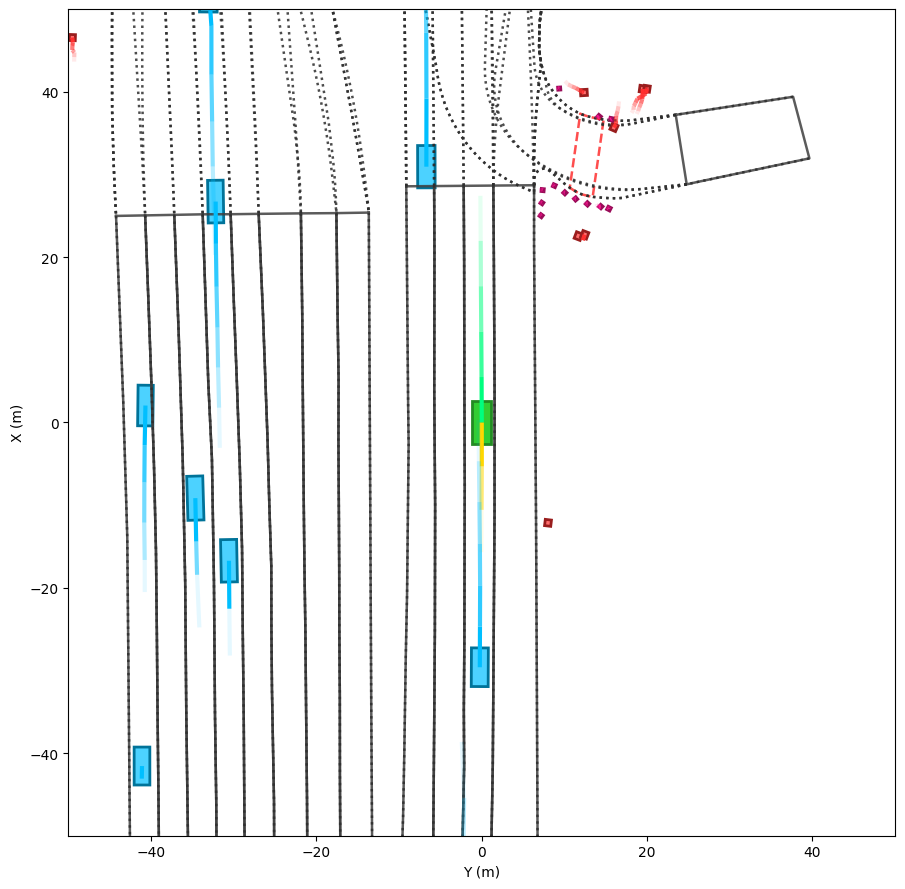

In [ ]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_train_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[140]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    # frame_indices=range(160, 200),
    out_path=Path("navsim_train_map_full.mp4"),
    fps=5
)

In [ ]:
# 파일 경로 설정
pkl_path = "data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl"

# 단일 프레임 플롯
infos = load_infos(Path(pkl_path))
info = infos[140]  # 첫 번째 프레임
fig, ax = plot_scene(info)
plt.show()

# 비디오 생성
render_infos_to_video(
    infos=infos,
    # frame_indices=range(160, 200),
    out_path=Path("navsim_val_map_full.mp4"),
    fps=5
)

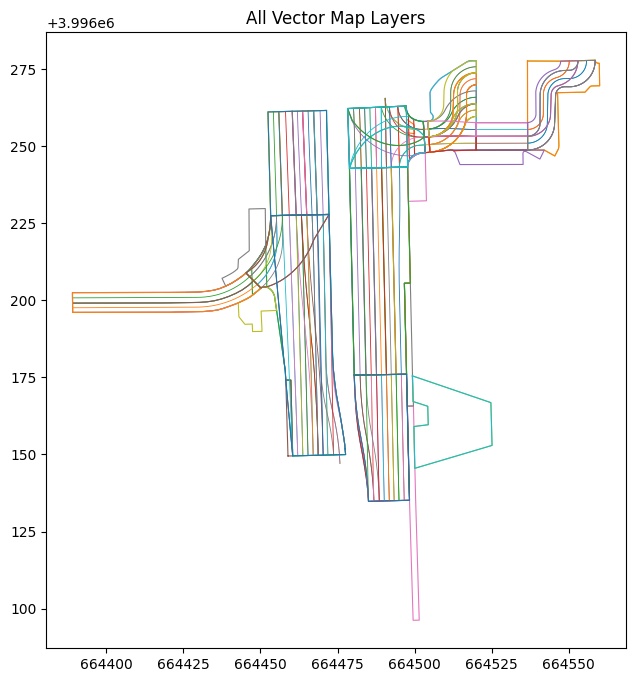

In [80]:
import mmcv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon, MultiLineString

data = mmcv.load("data/navsim_infos/vad_navsim_infos_temporal_train_start0_count1.pkl")
info = data["infos"][0]
vec_map = info["local_vector_map"]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

for layer_name, gdf in vec_map.items():
    if not hasattr(gdf, "geometry"):
        continue

    for geom in gdf.geometry:
        if geom.is_empty:
            continue

        if isinstance(geom, (Polygon, MultiPolygon)):
            if isinstance(geom, Polygon):
                geoms = [geom]
            else:
                geoms = list(geom.geoms)
            for g in geoms:
                x, y = g.exterior.xy
                ax.plot(x, y, linewidth=0.8)
        elif isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                geoms = [geom]
            else:
                geoms = list(geom.geoms)
            for g in geoms:
                x, y = g.xy
                ax.plot(x, y, linewidth=0.6)

ax.set_title("All Vector Map Layers")
plt.show()